# Predicting Hepatotoxicity Using ToxCast in Vitro Bioactivity and Chemical Structure

http://pubs.acs.org/doi/abs/10.1021/tx500501h

# Reproducing the results shown in Table 2


The following notebook provides step-by-step instructions for reproducing the results shown in Table 2 of [J. Liu, K. Mansouri, R. S. Judson, M. T. Martin, H. Hong, M. Chen, X. Xu, R. S. Thomas, and I. Shah, “Predicting hepatotoxicity using ToxCast in vitro bioactivity and chemical structure,” Chem. Res. Toxicol., vol. 28, no. 4, pp. 738–751, Apr. 2015](http://pubs.acs.org/doi/abs/10.1021/tx500501h). 

## Requirements

The following code has been tested on Microsoft Windows and RedHat Linux and should run on under Python 2.7 with the required libraries (see below). All of the requirements can be easily met by installing [Anaconda](https://www.continuum.io/downloads), which works on Windows/Linux/Mac. The following packages can be installed from the Unix command line (or the "Anaconda prompt" under Windows) using the ["conda"](http://conda.pydata.org/docs/using/pkgs.html#install-a-package) command:

* numpy==1.11.1
* scipy==0.17.1
* pandas==0.18.1
* scikit-learn==0.17.1

## Jupyter

[Jupyter notebook](http://jupyter.org/) is an interactive computing environment based and is freely available. It can be installed using Anaconda. Please the the documents about Jupyter or find a tutorial on YouTube.  After jupyter is installed read the [quickstart instructions](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/) to create a configuration file. Set the following variables in your jupyter_notebook_config.py:

```python
c.NotebookApp.notebook_dir = your_notebook_directory
c.NotebookApp.port = 7777
```

Start the notebook server from the command line using (I always run this in a [screen](https://www.gnu.org/software/screen/manual/screen.html)):

```
unix> jupyter notebook
```

To run the jupyter notebook server on Windows simply start "Jupyter Notebook" under the Anaconda2 menu. This will start a terminal and open a browser window. 

### Download this repository

Download this repository and extract the files under `your_notebook_directory`. 

### Open the notebook
 
You can open the notebook in Firefox or Google Chrome at http://localhost:7777. Select the folder `livertox-crt-2015-master` followed by `notebooks` and then select the file named `LivTox CRT 2016d.ipynb`



## Running the code

The code is broken out into blocks called 'cells.' You must *run* the cells sequentially from the beginning by 
(i) selecting a cell with the mouse pointer and (ii) press 'ctrl+enter' on the keyboard. Do not skip any of the cells. Alternatively, you can run all of the cells by select 'Cell->Run All' from the menu. 

## Print out some useful information about your system

In [1]:

import platform,sys

print("""Python version: %s
dist: %s
system: %s
machine: %s
platform: %s
version: %s
""" % (
    sys.version.split('\n'),
    str(platform.dist()),
    platform.system(),
    platform.machine(),
    platform.platform(),
    platform.version()
))

Python version: ['2.7.12 |Anaconda 4.1.1 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]']
dist: ('', '', '')
system: Windows
machine: AMD64
platform: Windows-7-6.1.7601-SP1
version: 6.1.7601



## Load all the required packages

In [2]:
import numpy as np
import pylab as pl
import pandas as pd

from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.cross_validation import StratifiedKFold,train_test_split

from time import time
import warnings
warnings.simplefilter('ignore')
import os
import subprocess
import warnings

import pandas as pd
import re
import bz2

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## Set up anyvariables and functions used by the analysis

In [4]:
# Store all classifiers in a dictionary
Classifiers1 = dict(LDA = LDA(),
                    NB= GaussianNB(), 
                    KNN1=KNeighborsClassifier(algorithm='auto',n_neighbors=3), 
                    SVCL0=SVC(kernel='linear'), 
                    SVCR0=SVC(C=1.0, cache_size=400, class_weight=None, coef0=0.0, degree=3,
                              gamma=10.0, kernel='rbf', max_iter=-1, probability=False, shrinking=True,
                              tol=0.0001, verbose=False),
                    CART0=DecisionTreeClassifier(max_depth=10))

DataSet = {}
Markers = {}


def selFeatsFilter(A,b,top=5):
    selector = SelectPercentile(f_classif, percentile=10)
    selector.fit(A, b)
    scores = -np.log10(selector.pvalues_)
    scores[np.isnan(scores)]=0
    np.argsort(scores)
    if top>len(scores): top=len(scores)
    return np.argsort(scores)[-top:]

def myScore(Y_test,Y_pred):
    X = dict(TP=np.sum(np.logical_and(Y_pred==1, Y_test==1)),
             TN=np.sum(np.logical_and(Y_pred==0, Y_test==0)),
             FP=np.sum(np.logical_and(Y_pred==1, Y_test==0)),
             FN=np.sum(np.logical_and(Y_pred==0, Y_test==1)))
    for i,v in X.iteritems(): v *= 1.0
    TP,TN,FP,FN = X['TP'],X['TN'],X['FP'],X['FN']
    return dict(cm=X,acc=1.0*(TP+TN)/(TP+TN+FP+FN),sens=1.0*TP/(TP+FN),spec=1.0*TN/(TN+FP))

def countPosNeg(X):
    n0=np.sum(X==0)
    n1=np.sum(X==1)
    if n1>n0: 
        return 1
    else:
        return 0

def trainAndTestClassifiers(X,Y,I_test,I_train,n_desc,dbg=False,
                            TOPD=Markers,CLSF=Classifiers1):
    X_test = X.ix[I_test,:]
    X_train = X.ix[I_train,:]
    Y_test = Y.ix[I_test]
    Y_train = Y.ix[I_train]
    F_best = selFeatsFilter(X_train,Y_train,n_desc)
    Perf_i   =[]
    Vote   =pd.DataFrame(np.zeros((len(I_test),len(CLSF))),columns=CLSF.keys())
    
    if dbg: print "Train",X_train.shape," Test",X_test.shape," n_desc",len(F_best)
    for nm,clf in CLSF.iteritems():
        if dbg: print nm
        try:
            if dbg: print " Training"
            clf.fit(X_train.ix[:,F_best], Y_train)
            if dbg: print " Testing"
            Y_pred = clf.predict(X_test.ix[:,F_best])
            Vote[nm]=Y_pred
            if dbg: print " Calc score"
            P_i = myScore(Y_test,Y_pred)
            if dbg: print " Make results"
            P = dict(cl=nm,sens=P_i['sens'],spec=P_i['spec'],
                     bacc=0.5*(P_i['sens']+P_i['spec']),
                     prec=precision_score(Y_test,Y_pred),
                     n_pos=np.sum(Y_train==1),n_neg=np.sum(Y_train==0),
                     n_desc=n_desc,
                     acc=accuracy_score(Y_test,Y_pred))
                
            Perf_i.append(P)
                             
        except:
            print "   %s Failed!" % nm
        
    # Now get the majority vote for the class
    Y_pred=Vote.apply(countPosNeg,axis=1)
    P_i = myScore(Y_test,Y_pred)
    P = dict(cl='ENSMB',sens=P_i['sens'],spec=P_i['spec'],
             bacc=0.5*(P_i['sens']+P_i['spec']),
             prec=precision_score(Y_test,Y_pred),
             n_pos=np.sum(Y_train==1),n_neg=np.sum(Y_train==0),
             n_desc=n_desc,
             acc=accuracy_score(Y_test,Y_pred))
    Perf_i.append(P)

    return pd.DataFrame(Perf_i)


def resampleBalCVLearn(n_pos,n_neg,trial=1,
                       n_desc_min=5,n_desc_max=70,n_desc_step=5,
                       K=10,DS=DataSet,TOPD=Markers,
                       CLSF=Classifiers1,dbg=False):
    """
    Creates a balanced undersampled subset of the data for K-fold CV testing n_reps times 
    Requires: DS (which is pushed by dview)

    """
    Data = DS['Data']
    Y_pos = Data[DS['pos_cls']]
    X_pos = Data[DS['Desc']].ix[Y_pos==1,:]
    N_pos = np.sum(Y_pos[Y_pos==1])
    
    Y_neg = Data[DS['neg_cls']]
    X_neg = Data[DS['Desc']].ix[Y_neg==1,:]
    N_neg = np.sum(Y_neg[Y_neg==1])

    I_pos = np.random.randint(0,N_pos,n_pos)
    X_pi = X_pos.ix[I_pos,:]
    X_pi['out']=1

    I_neg = np.random.randint(0,N_neg,n_neg)
    X_ni = X_neg.ix[I_neg,:]
    X_ni['out']=0

    X = pd.concat((X_pi,X_ni))
    Y = X['out']
    X = X.drop('out',axis=1)
    
    Perf_cv = []
    
    #pid=os.getpid()

    SKF = StratifiedKFold(Y,n_folds=K)
    i_step = 0
    for n_desc in range(n_desc_min,n_desc_max,n_desc_step):
        for I_train,I_test in SKF:
            i_step += 1
            if dbg: print 'Data',X.shape
            P_df=trainAndTestClassifiers(X,Y,I_test,I_train,n_desc,
                                         TOPD=Markers,CLSF=Classifiers1,dbg=dbg)
            P_df['n_obs']=n_pos+n_neg
            P_df['n_pos']=n_pos
            P_df['n_neg']=n_neg
            P_df['dtp'] = DS['dtp']
            P_df['tox'] = DS['tox']
            P_df['cvk'] = K
            P_df['itrl']= "%d-%d" % (trial,i_step)
            Perf_cv += P_df.T.to_dict().values()
        
    return Perf_cv

# The rest is just to make a summary table of performance results from all the replicates

C1=pd.MultiIndex.from_tuples(
[('n_desc', 'bio'),
 ('n_desc', 'chm'),
 ('n_desc', 'bc'),
 ('bacc', 'bio'),
 ('bacc', 'chm'),
 ('bacc', 'bc'),
 ('sens', 'bio'),
 ('sens', 'chm'),
 ('sens', 'bc'),
 ('spec', 'bio'),
 ('spec', 'chm'),
 ('spec', 'bc')])
ii_tox=0
ii_dtp=1
ii_cl =2
ii_cvk=3
ii_nds=4
ii_nob=5


def buildMSTable1(P_st,cols=C1):
    X= P_st.groupby(level=['tox','dtp','cl']).max()
    Tox=set([i[0] for i in X.index])
    Dtp=set([i[1] for i in X.index])
    CL =set([i[2] for i in X.index])
    Res=[]
    for tox in Tox:
        for dtp in Dtp:
            for cl in CL:
                Bacc=X.xs((tox,dtp,cl))['bacc']
                Y = P_st.xs((tox,dtp,cl)).reset_index()[['n_desc','bacc']]
                Y1 = Y[(Y['bacc']==Bacc)].n_desc
                #print tox,dtp,cl,Bacc,int(Y1)
                Res.append(dict(tox=tox,dtp=dtp,cl=cl,n_desc=int(list(Y1)[0])))
    Res_df = pd.DataFrame(Res).set_index(['tox','dtp','cl'])
    X = pd.merge(X,Res_df,left_index=True,right_index=True)
    #X['bacc2'] = X.apply(lambda x: "%3.2f(%d)"%(x[1],x[-1]),axis=1)

    T1 = np.round(pd.pivot_table(X.reset_index(),index=['tox','cl'],columns=['dtp'],values=['bacc','n_desc','sens','spec']),decimals=2)
    return T1[cols]

def buildMSTable2(P_mn,P_sd,cols=C1):
    IMB_mn = buildMSTable1(P_mn)
    IMB_sd = buildMSTable1(P_sd)

    if len(cols)>0: 
        C1 = cols 
    else:
        C1 = IMB_mn.columns
        
    R1=IMB_mn.index
    IMB_res = pd.DataFrame(columns=C1,index=R1)

    for i in [x for x in C1 if x[0]=='n_desc']:
        IMB_res[i] = IMB_mn[i]

    for r in R1:
        for c in [c for c in C1 if c[0]!='n_desc']:
            IMB_res.ix[r,c] = "%3.2f (%3.2f)" % (IMB_mn.ix[r,c],IMB_sd.ix[r,c]) 

    return IMB_res

def buildMSTable11(P_st,cols=C1):
    X= P_st.groupby(level=['tox','dtp']).max()
    Tox=set([i[0] for i in X.index])
    Dtp=set([i[1] for i in X.index])
    Res=[]
    for tox in Tox:
        for dtp in Dtp:
            Bacc=X.xs((tox,dtp))['bacc']
            Y = P_st.xs((tox,dtp)).reset_index()[['n_desc','bacc']]
            Y1 = Y[(Y['bacc']==Bacc)].n_desc
            #print tox,dtp,cl,Bacc,int(Y1)
            Res.append(dict(tox=tox,dtp=dtp,n_desc=int(list(Y1)[0])))
    Res_df = pd.DataFrame(Res).set_index(['tox','dtp'])
    X = pd.merge(X,Res_df,left_index=True,right_index=True)
    #X['bacc2'] = X.apply(lambda x: "%3.2f(%d)"%(x[1],x[-1]),axis=1)

    T1 = np.round(pd.pivot_table(X.reset_index(),index=['tox'],columns=['dtp'],values=['bacc','n_desc','sens','spec']),decimals=2)
    return T1[cols]

def buildMSTable21(P_mn,P_sd,cols=C1):
    IMB_mn = buildMSTable11(P_mn)
    IMB_sd = buildMSTable11(P_sd)

    if len(cols)>0: 
        C1 = cols 
    else:
        C1 = IMB_mn.columns
    
    R1=IMB_mn.index
    IMB_res = pd.DataFrame(columns=C1,index=R1)

    for i in [x for x in C1 if x[0]=='n_desc']:
        IMB_res[i] = IMB_mn[i]

    for r in R1:
        for c in [c for c in C1 if c[0]!='n_desc']:
            IMB_res.ix[r,c] = "%3.2f (%3.2f)" % (IMB_mn.ix[r,c],IMB_sd.ix[r,c]) 

    return IMB_res



## Load the data files and format the data sets

In [5]:
# The data file integrates chm, bio and tox data
import bz2
DF = pd.read_csv(bz2.BZ2File('../data/liv-tox-pred-1.csv.bz2','r'))
DF1 = DF.set_index(['cid','CASRN','name'])

In [6]:
#Figure out the columns for each descriptor
#print DF1.columns
Col_tox = ['Hypertrophy', 'Injury', 'Proliferative.lesions', 'No.liver.lesions']
Col_bio = [i for i in DF1.columns if re.search(r'^APR|^ATG|^ACEA|^NVS|^OT|^Tox21',i,re.I)]
Col_chm = [i for i in DF1.columns if i not in Col_tox+Col_bio]

print "Tox",len(Col_tox)," Bio",len(Col_bio)," Chm",len(Col_chm)

# Now create the different datasets for ML
#
# DataSet:
#   Desc: list of descriptors
#   pos_cls: name of positive class
#   neg_cls: name of negative class
#   dtp: descriptor type bio|chm|bc
#   Data: DataFrame containing all data
#   title: string name for the data set

ML1 = dict()
ML1['Inj-bio']=dict(Desc=Col_bio,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Injury ~ Bioactivity")

ML1['Hyp-bio']=dict(Desc=Col_bio,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Hypertrophy ~ Bioactivity")

ML1['Pro-bio']=dict(Desc=Col_bio,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Bioactivity")

ML1['Inj-chm']=dict(Desc=Col_chm,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Injury ~ Chem")

ML1['Hyp-chm']=dict(Desc=Col_chm,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Hypertrophy ~ Chem")

ML1['Pro-chm']=dict(Desc=Col_chm,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Chem")

ML1['Inj-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Injury ~ Bio + Chem")

ML1['Hyp-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Hypertrophy ~ Bio + Chem")

ML1['Pro-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Bio + Chem")

for tox,V in ML1.iteritems():
    V['tox']=tox.split('-')[0]
    


Tox 4  Bio 127  Chm 730


In [7]:
for tox,DS in ML1.iteritems():
    Data = DS['Data']
    pos  = DS['pos_cls']
    neg  = DS['neg_cls']
    
    print tox,np.sum(Data[pos]==1),np.sum(Data[neg]==1)


Pro-bc 99 463
Pro-chm 99 463
Inj-chm 101 463
Hyp-bio 161 463
Pro-bio 99 463
Hyp-chm 161 463
Inj-bio 101 463
Inj-bc 101 463
Hyp-bc 161 463


## Run the machine learning analysis

In [8]:
import sys, time
sys.stdout.flush()
    
PERF   = []
TOPDESC={}
i_trl = 0
for tox in ['Hyp-chm','Hyp-bio','Hyp-bc',
            'Inj-chm','Inj-bio','Inj-bc',
            'Pro-chm','Pro-bio','Pro-bc',
            ]:
    DS = ML1[tox]
    Markers = {}
    Res = []
    print "\n>>", DS['title'],len(PERF),time.strftime("%d/%m/%Y %H:%M",time.localtime())

    Data = DS['Data']
    Y_pos = Data[DS['pos_cls']]
    X_pos = Data[DS['Desc']].ix[Y_pos==1,:]
    N_pos = np.sum(Y_pos[Y_pos==1])
    Y_neg = Data[DS['neg_cls']]
    N_neg = np.sum(Y_neg[Y_neg==1])
    print "  >  No. of pos: %d neg: %d" % (N_pos,N_neg),time.strftime("%d/%m/%Y %H:%M",time.localtime())
    sys.stdout.flush()
    # This runs 5 undersampled datasets  -- need at least 20
    for i in range(20):
        i_trl+=1
        print "   Trial", i_trl
        Res += resampleBalCVLearn(n_pos=N_pos,n_neg=N_neg,trial=i_trl,
                                n_desc_min=10,n_desc_max=70,n_desc_step=5,
                                K=10,DS=DS,TOPD=Markers,CLSF=Classifiers1,dbg=False)

    PERF += Res
    TOPDESC[tox]=Markers


print "> ML analysis done ",time.strftime("%d/%m/%Y %H:%M",time.localtime())

PERF1_df = pd.DataFrame(PERF)
PERF1_df.set_index(['tox','dtp','cl','itrl','cvk','n_desc','n_pos','n_neg','n_obs'],inplace=True)
# These are variables used further below
TOP_DESC1=TOPDESC


>> Liver Hypertrophy ~ Chem 0 01/12/2016 10:49
  >  No. of pos: 161 neg: 463 01/12/2016 10:49
   Trial 1
   Trial 2
   Trial 3
   Trial 4
   Trial 5
   Trial 6
   Trial 7
   Trial 8
   Trial 9
   Trial 10
   Trial 11
   Trial 12
   Trial 13
   Trial 14
   Trial 15
   Trial 16
   Trial 17
   Trial 18
   Trial 19
   Trial 20

>> Liver Hypertrophy ~ Bioactivity 16800 01/12/2016 10:55
  >  No. of pos: 161 neg: 463 01/12/2016 10:55
   Trial 21
   Trial 22
   Trial 23
   Trial 24
   Trial 25
   Trial 26
   Trial 27
   Trial 28
   Trial 29
   Trial 30
   Trial 31
   Trial 32
   Trial 33
   Trial 34
   Trial 35
   Trial 36
   Trial 37
   Trial 38
   Trial 39
   Trial 40

>> Liver Hypertrophy ~ Bio + Chem 33600 01/12/2016 10:59
  >  No. of pos: 161 neg: 463 01/12/2016 10:59
   Trial 41
   Trial 42
   Trial 43
   Trial 44
   Trial 45
   Trial 46
   Trial 47
   Trial 48
   Trial 49
   Trial 50
   Trial 51
   Trial 52
   Trial 53
   Trial 54
   Trial 55
   Trial 56
   Trial 57
   Trial 58
   Tria

In [ ]:
!mkdir ../results/

In [ ]:
PERF1_df.to_csv("../results/perf-imbalanced-rep-20.tsv")

In [9]:
P2_mn = PERF1_df.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()
P2_sd = PERF1_df.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).std()


In [10]:
# FInd the rows containing the max number of examples
X = P2_mn.reset_index()
N_obs=X[['tox','n_obs']].groupby('tox').max().to_dict()['n_obs']
Y = []
for tox,n_obs in N_obs.iteritems():
    X1 = X[(X['tox']==tox) & (X['n_obs']==n_obs)]
    Y += [X1.irow(i).to_dict() for i in range(X1.shape[0])]
P21_mn = pd.DataFrame(Y)
P21_mn.set_index(['tox','dtp','cl','cvk','n_desc','n_obs'],inplace=True)
P21_mn = P21_mn.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()

X = P2_sd.reset_index()
Y = []
for tox,n_obs in N_obs.iteritems():
    X1 = X[(X['tox']==tox) & (X['n_obs']==n_obs)]
    Y += [X1.irow(i).to_dict() for i in range(X1.shape[0])]
P21_sd = pd.DataFrame(Y).set_index(['tox','dtp','cl','cvk','n_desc','n_obs'])
P21_sd = P21_sd.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()


In [11]:
Table5 = buildMSTable2(P21_mn,P21_sd)
Table5


n_desc                     bacc                            \
             bio   chm    bc          bio          chm           bc   
tox cl                                                                
Hyp CART0   60.0  65.0  65.0  0.80 (0.07)  0.83 (0.10)  0.84 (0.07)   
    ENSMB   65.0  65.0  65.0  0.77 (0.07)  0.75 (0.07)  0.78 (0.07)   
    KNN1    65.0  65.0  35.0  0.75 (0.07)  0.74 (0.10)  0.76 (0.09)   
    LDA     65.0  65.0  65.0  0.74 (0.07)  0.71 (0.07)  0.75 (0.07)   
    NB      15.0  60.0  60.0  0.73 (0.08)  0.71 (0.08)  0.77 (0.08)   
    SVCL0   65.0  65.0  65.0  0.75 (0.07)  0.69 (0.07)  0.75 (0.07)   
    SVCR0   65.0  65.0  30.0  0.77 (0.07)  0.77 (0.07)  0.80 (0.07)   
Inj CART0   65.0  60.0  65.0  0.74 (0.09)  0.81 (0.11)  0.81 (0.10)   
    ENSMB   65.0  65.0  65.0  0.72 (0.09)  0.71 (0.09)  0.74 (0.09)   
    KNN1    20.0  65.0  65.0  0.68 (0.10)  0.72 (0.10)  0.73 (0.10)   
    LDA     65.0  65.0  65.0  0.70 (0.09)  0.68 (0.09)  0.73 (0.09)   
    NB      15.0  60.0  30.0  0.68 (0.10)  0.69 (0.09)  0.75 (0.09)   
    SVCL0   65.0  65.0  65.0  0.68 (0.09)  0.65 (0.10)  0.71 (0.09)   
    SVCR0   65.0  65.0  65.0  0.76 (0.09)  0.75 (0.09)  0.77 (0.09)   
Pro CART0   40.0  65.0  65.0  0.75 (0.09)  0.78 (0.12)  0.79 (0.10)   
    ENSMB   65.0  65.0  65.0  0.71 (0.08)  0.70 (0.09)  0.71 (0.08)   
    KNN1    65.0  65.0  60.0  0.67 (0.10)  0.70 (0.10)  0.70 (0.10)   
    LDA     65.0  65.0  65.0  0.70 (0.08)  0.65 (0.09)  0.69 (0.09)   
    NB      60.0  65.0  60.0  0.68 (0.09)  0.70 (0.09)  0.72 (0.09)   
    SVCL0   60.0  65.0  65.0  0.68 (0.08)  0.63 (0.08)  0.67 (0.08)   
    SVCR0   65.0  65.0  65.0  0.75 (0.08)  0.73 (0.09)  0.76 (0.09)   

                  sens                                   spec               \
                   bio          chm           bc          bio          chm   
tox cl                                                                       
Hyp CART0  0.65 (0.14)  0.74 (0.20)  0.73 (0.15)  0.95 (0.04)  0.93 (0.05)   
    ENSMB  0.57 (0.13)  0.55 (0.14)  0.59 (0.14)  0.98 (0.03)  0.96 (0.05)   
    KNN1   0.62 (0.14)  0.62 (0.23)  0.63 (0.20)  0.92 (0.12)  0.89 (0.18)   
    LDA    0.54 (0.14)  0.51 (0.14)  0.57 (0.14)  0.95 (0.04)  0.91 (0.05)   
    NB     0.69 (0.15)  0.73 (0.17)  0.72 (0.14)  0.91 (0.20)  0.86 (0.15)   
    SVCL0  0.56 (0.14)  0.47 (0.14)  0.57 (0.15)  0.95 (0.04)  0.92 (0.05)   
    SVCR0  0.56 (0.16)  0.56 (0.14)  0.66 (0.15)  1.00 (0.04)  0.98 (0.05)   
Inj CART0  0.53 (0.18)  0.67 (0.24)  0.67 (0.20)  0.97 (0.03)  0.95 (0.05)   
    ENSMB  0.45 (0.18)  0.45 (0.22)  0.50 (0.19)  0.99 (0.02)  0.98 (0.05)   
    KNN1   0.50 (0.19)  0.52 (0.24)  0.53 (0.21)  0.94 (0.13)  0.93 (0.08)   
    LDA    0.46 (0.18)  0.42 (0.18)  0.51 (0.17)  0.97 (0.03)  0.94 (0.05)   
    NB     0.78 (0.23)  0.69 (0.19)  0.68 (0.18)  0.91 (0.26)  0.87 (0.17)   
    SVCL0  0.39 (0.17)  0.35 (0.23)  0.45 (0.20)  0.98 (0.03)  0.97 (0.06)   
    SVCR0  0.52 (0.18)  0.51 (0.22)  0.54 (0.20)  1.00 (0.03)  0.99 (0.05)   
Pro CART0  0.54 (0.18)  0.63 (0.25)  0.62 (0.20)  0.97 (0.03)  0.99 (0.04)   
    ENSMB  0.43 (0.16)  0.42 (0.17)  0.44 (0.17)  0.99 (0.02)  0.99 (0.03)   
    KNN1   0.48 (0.19)  0.50 (0.24)  0.50 (0.21)  0.94 (0.15)  0.91 (0.12)   
    LDA    0.45 (0.16)  0.37 (0.18)  0.43 (0.17)  0.97 (0.03)  0.94 (0.05)   
    NB     0.66 (0.22)  0.72 (0.20)  0.64 (0.18)  0.88 (0.26)  0.86 (0.13)   
    SVCL0  0.40 (0.16)  0.31 (0.17)  0.38 (0.16)  0.98 (0.03)  0.98 (0.04)   
    SVCR0  0.51 (0.17)  0.48 (0.17)  0.53 (0.18)  1.00 (0.02)  0.99 (0.03)   

                        
                    bc  
tox cl                  
Hyp CART0  0.96 (0.05)  
    ENSMB  0.98 (0.05)  
    KNN1   0.92 (0.13)  
    LDA    0.95 (0.05)  
    NB     0.87 (0.07)  
    SVCL0  0.95 (0.05)  
    SVCR0  0.99 (0.05)  
Inj CART0  0.97 (0.05)  
    ENSMB  0.98 (0.05)  
    KNN1   0.94 (0.11)  
    LDA    0.96 (0.05)  
    NB     0.87 (0.12)  
    SVCL0  0.97 (0.05)  
    SVCR0  1.00 (0.05)  
Pro CAR

## Compare the above with the published table 

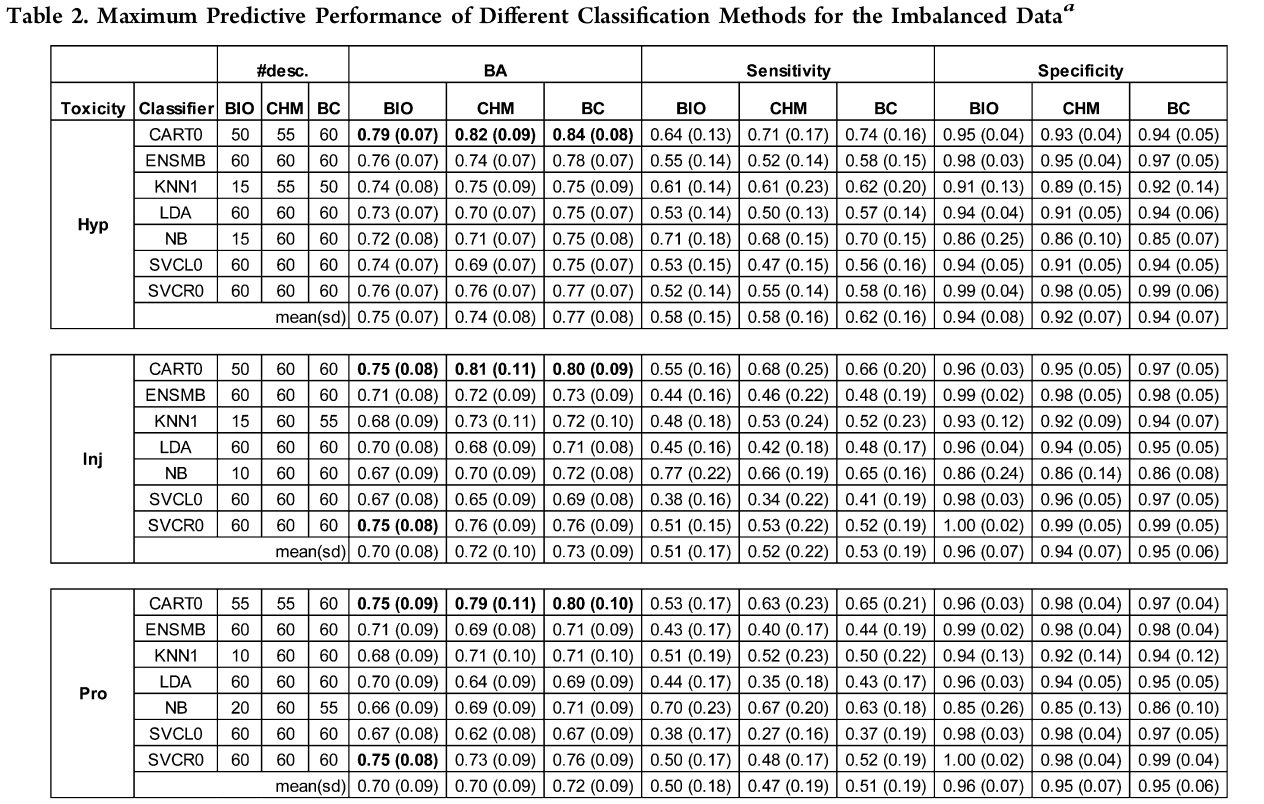

In [12]:
from IPython.display import Image
Image(filename='../results/CRT-Table-2.png')